# visualization

## import 

In [2]:
from __future__ import print_function
import sys
from syslog import LOG_MAIL

from urllib3 import Retry
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import random
import os
import argparse
import numpy as np
from PreResNet_cifar import *
import dataloader_cifar as dataloader
from math import log2
from Contrastive_loss import *

import collections.abc
from collections.abc import MutableMapping
from flow_trainer import FlowTrainer
from flowModule.utils import standard_normal_logprob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget


# project_path = './checkpoint/cifar10_sym_0.9_flow_fix_coslr_opt_flow_lr_u_3_len_340_tau_2.5_norm'
project_path = './checkpoint/cifar10_sym_0.9_flow_fix_coslr_opt_flow_lr_u_3_len_340_tau_2.5_norm'

isFlow = True
num_samples = 50000
if isFlow:
    model_name_warmup = 'Net_warmup.pth'
    model_name_flow_warmup = 'FlowNet_warmup.pth'

    model_name = 'Net.pth'
    model_name_flow = 'FlowNet.pth'
else:
    model_name_warmup = 'Net1_warmup.pth'
    model_name = 'Net1.pth'
    model_name_warmup_2 = 'Net2_warmup.pth'
    model_name_2 = 'Net2.pth'


In [3]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR Training')
parser.add_argument('--batch_size', default=256, type=int, help='train batchsize') 
parser.add_argument('--lr', '--learning_rate', default=0.02, type=float, help='initial learning rate')
parser.add_argument('--noise_mode',  default='sym')
parser.add_argument('--alpha', default=4, type=float, help='parameter for Beta')
parser.add_argument('--lambda_u', default=30, type=float, help='weight for unsupervised loss')
parser.add_argument('--lambda_c', default=0.025, type=float, help='weight for contrastive loss')
parser.add_argument('--T', default=0.5, type=float, help='sharpening temperature')
parser.add_argument('--num_epochs', default=350, type=int)
parser.add_argument('--r', default=0.9, type=float, help='noise ratio')
parser.add_argument('--d_u',  default=0.47, type=float)
parser.add_argument('--tau', default=2.5, type=float, help='filtering coefficient')
parser.add_argument('--metric', type=str, default = 'JSD', help='Comparison Metric')
parser.add_argument('--seed', default=123)
parser.add_argument('--gpuid', default=0, type=int)
parser.add_argument('--resume', default=False, type=bool, help = 'Resume from the warmup checkpoint')
parser.add_argument('--num_class', default=10, type=int)
parser.add_argument('--data_path', default='./data/cifar10', type=str, help='path to dataset')
parser.add_argument('--dataset', default='cifar10', type=str)
parser.add_argument('--flow_modules', default="8-8-8-8", type=str)
parser.add_argument('--name', default="", type=str)
args = parser.parse_args(args=[])

print(args)

Namespace(T=0.5, alpha=4, batch_size=256, d_u=0.47, data_path='./data/cifar10', dataset='cifar10', flow_modules='8-8-8-8', gpuid=0, lambda_c=0.025, lambda_u=30, lr=0.02, metric='JSD', name='', noise_mode='sym', num_class=10, num_epochs=350, r=0.9, resume=False, seed=123, tau=2.5)


## load model

In [4]:
def create_model():
    model = ResNet18(num_classes=args.num_class)
    model = model.cuda()
    return model
def resume_model(path):
    net_warmup.load_state_dict(torch.load(os.path.join(path, model_name_warmup))['net'])
    net.load_state_dict(torch.load(os.path.join(path, model_name))['net'])
    if isFlow:
        flowNet_warmup.load_state_dict(torch.load(os.path.join(path, model_name_flow_warmup))['net'])
        flowNet.load_state_dict(torch.load(os.path.join(path, model_name_flow))['net'])
    else:
        net_warmup_2.load_state_dict(torch.load(os.path.join(path, model_name_warmup_2))['net'])
        net_2.load_state_dict(torch.load(os.path.join(path, model_name_2))['net'])

In [5]:
# load encoder
net_warmup = create_model()
net = create_model()

# load flow model
if isFlow:
    flowTrainer = FlowTrainer(args)
    flowNet_warmup = flowTrainer.create_model()    
    flowNet = flowTrainer.create_model()   
else:
    net_warmup_2 = create_model()
    net_2 = create_model()
resume_model(project_path)

Training T : 1.0
Number of trainable parameters of Point CNF: 11313
Training T : 1.0
Number of trainable parameters of Point CNF: 11313


## load data loader

In [6]:
noise_file = '%s/clean_%.4f_%s.npz'%(args.data_path,args.r, args.noise_mode)
## Call the dataloader
loader = dataloader.cifar_dataloader(args.dataset, r=args.r, noise_mode=args.noise_mode,batch_size=args.batch_size,num_workers=0,\
    root_dir=project_path,log="", noise_file=noise_file)
test_loader = loader.run(0, 'test')
eval_loader = loader.run(0, 'eval_train')

In [7]:
noise_file

'./data/cifar10/clean_0.9000_sym.npz'

## test

In [18]:
## Test Accuracy
def test(net1,net2):
    net1.eval()
    net2.eval()

    num_samples = 1000
    correct = 0
    total = 0
    loss_x = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            _, outputs1 = net1(inputs)
            _, outputs2 = net2(inputs)           
            outputs = outputs1+outputs2
            _, predicted = torch.max(outputs, 1)            
#             loss = CEloss(outputs, targets)  
#             loss_x += loss.item()

            total += targets.size(0)
            correct += predicted.eq(targets).cpu().sum().item()  

    acc = 100.*correct/total
    return acc

In [8]:
if isFlow:
    acc_flow_warmup, confidence_warmup = flowTrainer.testByFlow(net_warmup, flowNet_warmup, test_loader)
    acc_flow, confidence = flowTrainer.testByFlow(net, flowNet, test_loader)
    print("acc(warmup) ", acc_flow_warmup, ", acc(flow) = ", acc_flow)
    print("confidence(warmup) ", confidence_warmup, ", confidence(flow) = ", confidence)
else:
    acc = test(net,net_2)
    acc_warmup = test(net_warmup,net_warmup_2)
    print("acc(warmup) ", acc_warmup, ", acc(flow) = ", acc)

acc(warmup)  34.09 , acc(flow) =  61.2
confidence(warmup)  0.12860390090942384 , confidence(flow) =  0.5537863014221192


## compare JSD, flow density

In [11]:
# KL divergence
def kl_divergence(p, q):
    return (p * ((p+1e-10) / (q+1e-10)).log()).sum(dim=1)

## Jensen-Shannon Divergence 
class Jensen_Shannon(nn.Module):
    def __init__(self):
        super(Jensen_Shannon,self).__init__()
        pass
    def forward(self, p,q):
        m = (p+q)/2
        return 0.5*kl_divergence(p, m) + 0.5*kl_divergence(q, m)
## Calculate JSD
def Calculate_JSD(model1, model2, num_samples):  
    JS_dist = Jensen_Shannon()
    JSD   = torch.zeros(num_samples)    

    for batch_idx, (inputs, targets, index) in tqdm(enumerate(eval_loader)):
        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]

        ## Get outputs of both network
        with torch.no_grad():
            out1 = torch.nn.Softmax(dim=1).cuda()(model1(inputs)[1])     
            out2 = torch.nn.Softmax(dim=1).cuda()(model2(inputs)[1])

        ## Get the Prediction
        out = (out1 + out2)/2     

        ## Divergence clculator to record the diff. between ground truth and output prob. dist.  
        dist = JS_dist(out,  F.one_hot(targets, num_classes = args.num_class))
        JSD[int(batch_idx*batch_size):int((batch_idx+1)*batch_size)] = dist
    return JSD

def Calculate_JSD_Flow(net, flowNet, num_samples):  
    JS_dist = Jensen_Shannon()
    JSD   = torch.zeros(num_samples)    

    for batch_idx, (inputs, targets, index) in tqdm(enumerate(eval_loader)):
        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]

        ## Get outputs of both network
        with torch.no_grad():
            feature = net(inputs)[0]
            out = flowTrainer.predict(flowNet, feature)

        ## Divergence clculator to record the diff. between ground truth and output prob. dist.  
        dist = JS_dist(out,  F.one_hot(targets, num_classes = args.num_class))
        JSD[int(batch_idx*batch_size):int((batch_idx+1)*batch_size)] = dist

    return JSD

In [12]:
if isFlow:
    prob = Calculate_JSD_Flow(net, flowNet, num_samples)
    # prob = Calculate_JSD_Flow(net_warmup, flowNet_warmup, num_samples)
else:
    prob = Calculate_JSD(net, net_2, num_samples)
#     prob = Calculate_JSD(net_warmup, net_warmup_2, num_samples)
threshold = torch.mean(prob)
if threshold.item()>args.d_u:
    threshold = threshold - (threshold-torch.min(prob))/args.tau
SR = torch.sum(prob<threshold).item()/num_samples    

500it [01:37,  5.15it/s]


In [13]:
labeled_trainloader, unlabeled_trainloader = loader.run(SR, 'train', prob = prob) # Uniform Selection

labeled_idx = labeled_trainloader.dataset.pred_idx
unlabeled_idx = unlabeled_trainloader.dataset.pred_idx
class_ind = labeled_trainloader.dataset.class_ind
origin_prob =  labeled_trainloader.dataset.origin_prob
labeled_prob = [origin_prob[i].numpy() for i in labeled_idx]
unlabeled_prob = [origin_prob[i].numpy() for i in unlabeled_idx]
sample_ratio = torch.sum(prob<threshold).item()/num_samples

In [14]:
noise_label = np.load(noise_file)['label']
noise_idx = np.load(noise_file)['index']
idx       = list(range(50000))
clean_idx = [x for x in idx if x not in noise_idx]

In [15]:
## True Positive
TP = [x for x in labeled_idx if x in clean_idx]
## False Positive
FP = [x for x in labeled_idx if x in noise_idx]

In [16]:
print("TP :", len(TP), "FP:", len(FP))

TP : 4789 FP: 6069


In [17]:
TP_classes = []
NP_classes = []
for i in range(0, 10):
    TP_classes.append(len([x for x in TP if x in class_ind[i]]))
    NP_classes.append(len([x for x in FP if x in class_ind[i]]))

## Selection (TP FP)

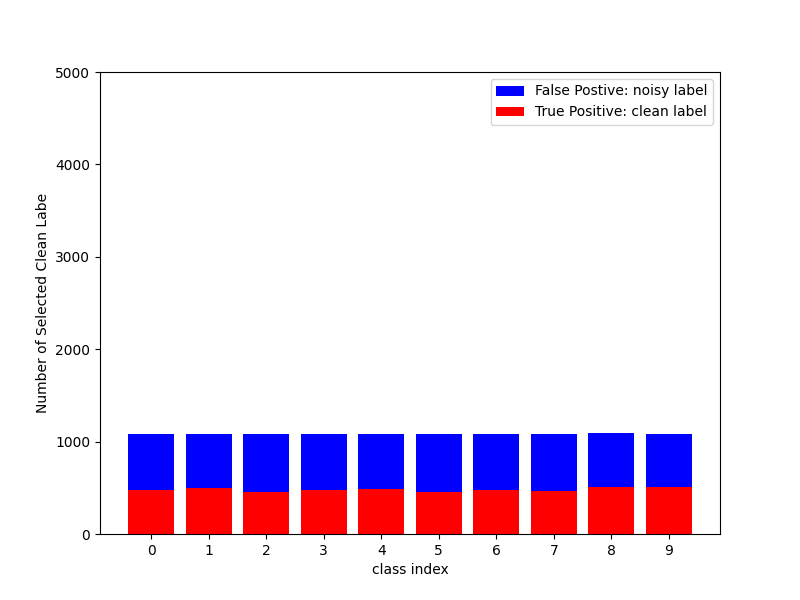

In [22]:
label = ['0','1','2','3','4','5','6','7','8','9']

plt.figure(figsize=(8,6))
x = np.arange(len(label))
plt.bar(x, NP_classes, color='blue', label='False Postive: noisy label', bottom=TP_classes)
plt.bar(x, TP_classes, color='red', label='True Positive: clean label')

plt.xticks(x, label)
plt.xlabel('class index')
plt.ylabel('Number of Selected Clean Labe')
plt.legend(loc='upper right')
plt.ylim((0,5000))
plt.show()

## JSD distribution

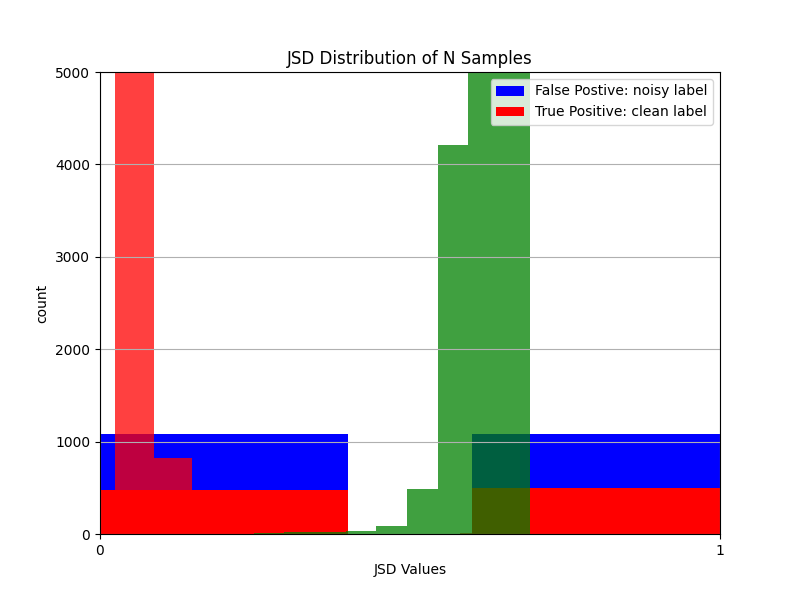

In [23]:
# the histogram of the data

labeled_prob = np.array(labeled_prob)
unlabeled_prob = np.array(unlabeled_prob)

# label_data = np.sort(labeled_prob)
# label_data_y = np.arange(len(label_data))/float(len(label_data))
# plt.plot(label_data, label_data_y)


# unlabeled_data = np.sort(unlabeled_prob)
# unlabeled_data_y = np.arange(len(unlabeled_data))/float(len(unlabeled_data))
# plt.plot(unlabeled_data, unlabeled_data_y)

kwargs = dict(histtype='stepfilled', alpha=0.75, density=False, bins=10)
# plt.hist(np.array(origin_prob), **kwargs)
plt.hist(labeled_prob, color = 'r', **kwargs)
plt.hist(unlabeled_prob, color = 'g',  **kwargs)


plt.xlabel('JSD Values')
plt.ylabel('count')
plt.title('JSD Distribution of N Samples')
plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.grid(True)
plt.show()

## Get density

In [12]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).cuda()
    return torch.index_select(a, dim, order_index)
def generateDensity(encoder, flownet, dataloader):
    encoder.eval()
    flownet.eval()
    
    approx21_vec = []
    log_p2_vec = []
    num_iter = (len(dataloader.dataset)//dataloader.batch_size)+1
    with torch.no_grad():
        input_y = torch.zeros(size=(dataloader.batch_size * args.num_class, 1, args.num_class)).cuda()
        for b in range(dataloader.batch_size):
            for c in range(args.num_class):
                input_y[args.num_class * b + c, 0, c] = 1.
        print(input_y[:10])
        for batch_idx, (inputs, labels) in tqdm(enumerate(dataloader)):
            inputs, labels = inputs.cuda(), labels.cuda() 
            feature, _ = encoder(inputs)
            feature = F.normalize(feature, dim=1)
#             print(feature[:5])
            feature = tile(feature, 0, args.num_class).unsqueeze(0)
            delta_p = torch.zeros(input_y.shape[0], input_y.shape[1], 1).cuda()
#             print(input_y.size(), feature.size(), delta_p.size())
#             print(input_y[:2], feature[:2], delta_p[:2])
            approx21, delta_log_p2 = flownet(input_y, feature, delta_p)
            approx2 = standard_normal_logprob(approx21).view(input_y.size()[0], -1).sum(1, keepdim=True)
            delta_log_p2 = delta_log_p2.view(input_y.size()[0], input_y.shape[1], 1).sum(1)
            log_p2 = (approx2 - delta_log_p2)
            approx21_vec.append(approx21.data.cpu())
            log_p2_vec.append(log_p2.data.cpu())
        approx21_vec = torch.cat(approx21_vec, dim=0)
        log_p2_vec = torch.cat(log_p2_vec, dim=0)
#             print(approx21.size())
#             print(approx2.size())
            
    return approx21_vec, log_p2_vec, dataloader.dataset.test_label

In [324]:
approx21, density,labels  = generateDensity(net, flowNet, test_loader)
print(approx21[20:30])
print(density[20:30])
print(labels[2:3])
print(approx21.size())
print(density.size())
print(len(labels))

0it [00:00, ?it/s]

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0')


100it [00:28,  3.55it/s]

tensor([[[ 8.3192e+00, -3.1501e+00,  1.6775e-01,  2.8688e-02,  1.2270e-01,
           1.1613e-01,  9.3875e-02, -3.9935e-01, -5.3352e+00,  4.9174e-02]],

        [[-2.3456e-02,  6.9501e+00,  1.8058e-01,  4.3245e-02,  1.0382e-01,
           1.2864e-01,  9.9754e-02, -4.6514e-01, -5.3899e+00,  5.6694e-02]],

        [[ 4.9999e-03, -3.1361e+00,  8.1212e+00,  3.1997e-02,  9.5456e-02,
           1.1967e-01,  9.9832e-02, -4.7993e-01, -5.3717e+00,  6.7844e-02]],

        [[ 5.3395e-04, -3.1359e+00,  1.8669e-01,  7.5407e+00,  9.3633e-02,
           1.1946e-01,  9.8797e-02, -4.7059e-01, -5.3823e+00,  5.7551e-02]],

        [[-4.3824e-02, -3.1540e+00,  1.5208e-01,  4.3649e-02,  7.9513e+00,
           1.2663e-01,  9.4666e-02, -3.8400e-01, -5.3305e+00,  4.7158e-02]],

        [[-3.9439e-02, -3.1495e+00,  1.6363e-01,  4.3264e-02,  1.3266e-01,
           7.7934e+00,  9.4061e-02, -3.9082e-01, -5.3402e+00,  4.5323e-02]],

        [[-4.2476e-02, -3.1521e+00,  1.5463e-01,  4.7195e-02,  1.4616e-01,
       

In [325]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(density.cpu().numpy())
X_embedded.shape

(100000, 2)

In [330]:
emb_dist = {}
labels10 = [0,1,2,3,4,5,6,7,8,9]
for i in [0,1,2,3,4,5,6,7,8,9]:
    ix = np.where(i == np.asarray(labels10))
    emb_dist[i] = X_embedded[ix]

In [331]:
def pltDis(target ,emb):
    result = np.array(emb)
    print(len(result))
    result_min, result_max = result.min(), result.max()
    result_norm = (result - result_min) / (result_max - result_min)
    # Project PNG
    x_axis = result_norm[:,0]
    y_axis = result_norm[:,1]
    count = int(len(result) / 10)
    c =  np.array([0,1,2,3,4,5,6,7,8,9] * count)
    plt.figure(figsize=(12, 12))
#     plt.xlim(0,1)
#     plt.ylim(0,1)

    cdict = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:red', 4: 'tab:purple', 5:'tab:brown', 6:'tab:pink', 7:'tab:gray', 8:'tab:olive', 9:'tab:cyan'}

    for color in np.unique(c):
        ix = np.where(c == color)
        if target == color:
            m = '*'
        else:
            m = 'o'
        plt.scatter(x_axis[ix], y_axis[ix], c=cdict[color], alpha=0.3, marker = m)
    plt.legend(['0','1','2','3','4','5','6','7','8','9'])
    plt.savefig('DR.png')

100000


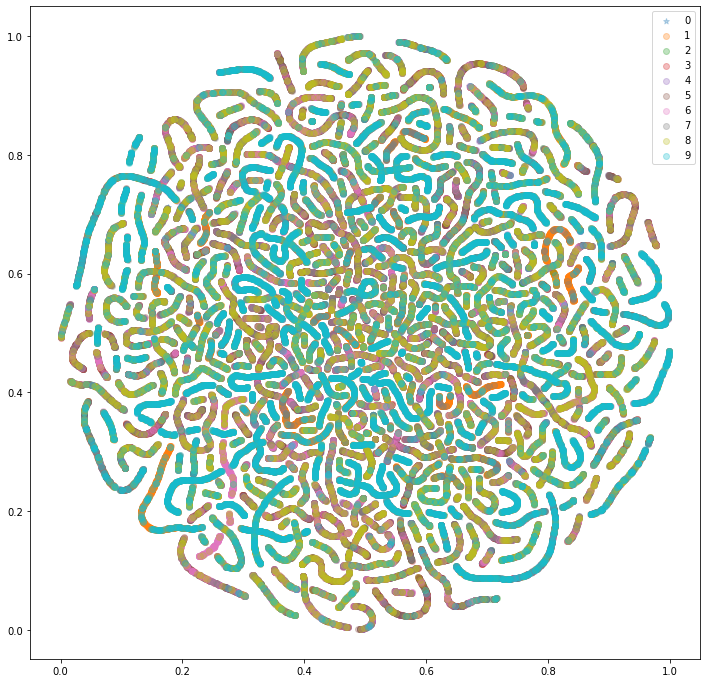

In [332]:
pltDis(0, X_embedded)

In [19]:
def pltDisV2(target, emb, density):
    result = np.array(emb)
    result_min, result_max = result.min(), result.max()
    result_norm = (result - result_min) / (result_max - result_min)
    # Project PNG
    x_axis = result_norm[:,0]
    y_axis = result_norm[:,1]
    z_axis = density
    c =  labels10
    plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')

#     plt.xlim(0,1)
#     plt.ylim(0,1)

    cdict = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:red', 4: 'tab:purple', 5:'tab:brown', 6:'tab:pink', 7:'tab:gray', 8:'tab:olive', 9:'tab:cyan'}
    m = ['o', '*', 's', 'P', 'p', 'x', 'X', 'd', 'h', 'H']

    for color in np.unique(c):
        ix = np.where(c == color)
        ij = []
#         print(color)
#         print(ix[0][:20])
        for j in ix[0]:
            if (j % 10) == color:
                ij.append(j)
        if (color == target):
            ax.scatter(x_axis[ix], y_axis[ix], z_axis[ix],  c=cdict[0], alpha=0.1, marker = m[color])
            ax.scatter(x_axis[ij], y_axis[ij], z_axis[ij], c=cdict[3], alpha=1, marker = 'H')

    plt.legend(['0','1','2','3','4','5','6','7','8','9'])
    plt.savefig('DR.png')
    plt.show()

In [20]:
pltDisV2(5, X_embedded, density)

NameError: name 'X_embedded' is not defined

In [8]:
def showDensity(data, classId):
    # plt.cla()
    plt.figure(figsize=(12,6))

    label=['0','1','2','3','4','5','6','7','8','9', 'c']
    color=['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red']
    x=np.arange(len(label)) 
    ax=plt.gca()
    plt.title(f"Density (label : {classId})") 
    bars = ax.bar(x, data, tick_label=label, color = color)
    ax.bar_label(bars)
    plt.grid(True)
    plt.xlabel('Class')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

In [9]:
def iter_load_model(mID):
    # path = './checkpoint/cifar10_sym_0.9_flow_lambda_u_3_lin_u_340_tau_2.5_saveAll'
    path = './checkpoint/cifar10_sym_0.9_flow_lambda_u_3_lin_u_340_tau_2.5_fixbug'
    model_name = f'Net_{mID}.pth'
    model_name_flow = f'FlowNet_{mID}.pth'
    net.load_state_dict(torch.load(os.path.join(path, model_name))['net'])
    flowNet.load_state_dict(torch.load(os.path.join(path, model_name_flow))['net'])
    return net, flowNet

In [10]:
def drawBar(data):
    langs=['0','1','2','3','4','5','6','7','8','9']
    plt.ylim(0, 1)
    plt.bar(langs,data)
    plt.show()

In [16]:
%matplotlib inline

from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, FloatSlider, IntSlider
from IPython.display import Image

test_b1_loader = loader.run(0, 'test')
@interact
def visDensity(
    idx = IntSlider(min=0, max=test_b1_loader.batch_size - 1, step=1, value=0),
    modelIdx = IntSlider(min=0, max=23, step=1, value=0),
    modelType = widgets.RadioButtons(options=['best', 'warmup', 'debug'], value='best', description='modelType', disabled=False),
    viewer = widgets.RadioButtons(options=['density', 'sharpen'], value='density', description='viewer', disabled=False),
    T = FloatSlider(min=0., max=5., value=0.5, step=0.01),
    inputX_0 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_1 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_2 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_3 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_4 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_5 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_6 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_7 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_8 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_9 = FloatSlider(min=0., max=1., value=0., step=0.01),
):
    print("modelType : ", modelType)
    if (modelType == 'best'):
        netModel = net
        flowModel = flowNet
    elif(modelType == 'warmup'):
        netModel = net_warmup
        flowModel = flowNet_warmup
    elif(modelType == 'debug'):
        netModel, flowModel = iter_load_model(modelIdx)
    netModel.eval()
    flowModel.eval()   
    approx21_vec = []
    log_p2_vec = []
    preidct_vec = []
    data_size = args.num_class + 1
    inputX = [inputX_0, inputX_1, inputX_2,inputX_3,inputX_4,inputX_5,inputX_6,inputX_7,inputX_8,inputX_9]
    inputX = torch.FloatTensor(inputX)

    with torch.no_grad():
        input_y = torch.zeros(size=(test_b1_loader.batch_size * data_size, 1, args.num_class)).cuda()
        for b in range(test_b1_loader.batch_size):
            for c in range(args.num_class):
                input_y[(data_size * b) + c, 0, c] = 1.
            input_y[(data_size * b) + 10] = inputX
            
        for batch_idx, (inputs, labels) in enumerate(test_b1_loader):
            inputs, labels = inputs.cuda(), labels.cuda() 
            feature, _ = netModel(inputs)
            feature = F.normalize(feature, dim=1)
            # get density
            feature_rp = tile(feature, 0, data_size).unsqueeze(0)
            delta_p = torch.zeros(input_y.shape[0], input_y.shape[1], 1).cuda()
            # print("input_y", input_y.size())
            # print("feature_rp", feature_rp.size())
            # print("delta_p", delta_p.size())
            approx21, delta_log_p2 = flowModel(input_y, feature_rp, delta_p)
            approx2 = standard_normal_logprob(approx21).view(input_y.size()[0], -1).sum(1, keepdim=True)
            delta_log_p2 = delta_log_p2.view(input_y.size()[0], input_y.shape[1], 1).sum(1)
            log_p2 = (approx2 - delta_log_p2)
            approx21_vec.append(approx21.data.cpu())
            log_p2_vec.append(log_p2.data.cpu())
            
            # get predict
            input_z = torch.normal(mean = 0, std = 0, size=(test_b1_loader.batch_size, 1, args.num_class)).cuda()
            delta_p = torch.zeros(input_z.shape[0], input_z.shape[1], 1).cuda()
            # print("input_z", input_z.size())
            # print("feature", feature.size())
            # print("delta_p", delta_p.size())
            approx21, _ = flowModel(input_z, feature, delta_p, reverse=True)
            # print("approx21", approx21.size() , approx21[idx])
            probs = torch.clamp(approx21, min=0, max=1)
            # print("probs_1", probs.size(), probs[idx])
            probs = probs.view(1, -1, args.num_class)
            # print("probs_2", probs.size(), probs[:3])
            probs_mean = torch.mean(probs, dim=0, keepdim=False)
            probs_mean = F.normalize(probs_mean, dim=1, p=1)
            preidct_vec.append(probs_mean.data.cpu())
            _, predicted = torch.max(probs_mean, 1)
            # print("predicted : ", predicted[idx])
            break
        approx21_vec = torch.cat(approx21_vec, dim=0)
        log_p2_vec = torch.cat(log_p2_vec, dim=0)
        preidct_vec = torch.cat(preidct_vec, dim=0)
        pu = preidct_vec**(1/T)
        preidct_sharpen_vec = pu / pu.sum(dim=1, keepdim=True)
        # print("preidct_vec : ", preidct_vec[idx])
        # print("preidct_sharpen : ", preidct_sharpen_vec[idx])
        # print("GT : ", test_b1_loader.dataset.test_label[idx])
        if (viewer == "sharpen"):
            drawBar(preidct_vec[idx].numpy())
            drawBar(preidct_sharpen_vec[idx].numpy())
        elif(viewer == "density"):
            print("X_c : ", inputX)
            showDensity(log_p2_vec[idx*11:(idx + 1)*11], test_b1_loader.dataset.test_label[idx])
    return 

interactive(children=(IntSlider(value=0, description='idx', max=99), IntSlider(value=0, description='modelIdx'…